In [1]:
import matplotlib
matplotlib.rcParams['pdf.fonttype'] = 42
matplotlib.rcParams['ps.fonttype'] = 42

In [2]:
!pip install git+https://github.com/pabloppp/pytorch-tools -U

  Cloning https://github.com/pabloppp/pytorch-tools to /tmp/pip-req-build-r_5u9rx1
  Running command git clone -q https://github.com/pabloppp/pytorch-tools /tmp/pip-req-build-r_5u9rx1
  Created wheel for torchtools: filename=torchtools-0.2.4-cp36-none-any.whl size=19202 sha256=1da484efa7909d50ccf1486e0826360846649d297adaad8d0dc3bdde0f0e1ea4
  Stored in directory: /tmp/pip-ephem-wheel-cache-jlh0h2_l/wheels/53/7a/b0/86ffb126404564b151069f4d8d9f43dbfe3f17bfc0b898b45f
Successfully built torchtools


In [1]:
from torchtools.nn import Mish
from torchtools.nn import SimpleSelfAttention

In [2]:
import numpy as np

from sklearn.preprocessing import scale
from sklearn.preprocessing import normalize

from sklearn.model_selection import train_test_split
from scipy.signal import sawtooth, square, detrend

from torch.autograd import Variable
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torch.utils.data as data_utils
from torch.utils.data import Dataset, DataLoader

import torch

from torch.utils.tensorboard import SummaryWriter
from torchsummary import summary
import os

import random
import glob

import matplotlib.pyplot as plt



In [3]:
from google.colab import drive
drive.mount('/gdrive', force_remount=True)

Mounted at /gdrive


In [4]:
def plot_tb_figure(signal, estimates):
    fig, ax = plt.subplots(nrows=estimates.shape[1]+2, ncols=1, figsize=(12,9))

    for i in range(0,signal.shape[1]):
      
        estimates_plot = estimates[0,i,:].squeeze().detach().cpu().numpy()
        signal_plot = signal[0,i,:].detach().cpu().numpy()

        estimates_plot = normalize(estimates_plot[:,np.newaxis], axis=0).ravel()
        signal_plot = normalize(signal_plot[:,np.newaxis], axis=0).ravel()
    
        ax[i].plot(estimates_plot, color='red')
        ax[i].plot(signal_plot, color='green', alpha=0.5)
        ax[i].set_title('Trace %i' %i)

    ax[i+1].plot(np.sum(estimates[0,:,:].squeeze().detach().cpu().numpy(), axis=0), color='blue', alpha=0.5)
    ax[i+1].plot(np.sum(signal[0,:,:].detach().cpu().numpy(), axis=0), color='green', alpha=0.5)
    ax[i+1].set_title('Input signal - Mix of signals')

    residual = np.sum(signal[0,:,:].detach().cpu().numpy(), axis=0)**2 - np.sum(estimates[0,:,:].squeeze().detach().cpu().numpy(), axis=0)**2
    ax[i+2].plot(residual, color='purple')
    ax[i+2].set_title('Residual')
    return fig

# plot_tb_figure(signal, signal);

In [5]:
from itertools import permutations
EPS = 1e-32

class _Loss(nn.Module):
    def __init__(self, size_average=None, reduce=None, reduction='mean'):
        super(_Loss, self).__init__()
        if size_average is not None or reduce is not None:
            self.reduction = _Reduction.legacy_get_string(size_average, reduce)
        else:
            self.reduction = reduction

class SI_SDR_Loss(_Loss):
    def __init__(self):
        super(SI_SDR_Loss, self).__init__()

    def cal_loss(source, estimate_source):
        """
        Args:
            source: [B, C, T], B is batch size
            estimate_source: [B, C, T]
            source_lengths: [B]
        """
        source_lengths = torch.LongTensor([source.size()[2]]*source.size()[0]).T.to(device)
        max_snr, perms, max_snr_idx = SI_SDR_Loss.cal_si_snr_with_pit(source,
                                                        estimate_source,
                                                        source_lengths)
        loss = 0 - torch.mean(max_snr)
        reorder_estimate_source = SI_SDR_Loss.reorder_source(estimate_source, perms, max_snr_idx)
        
        return loss, max_snr, estimate_source, reorder_estimate_source


    def cal_si_snr_with_pit(source, estimate_source, source_lengths):
        """Calculate SI-SNR with PIT training.
        Args:
            source: [B, C, T], B is batch size
            estimate_source: [B, C, T]
            source_lengths: [B], each item is between [0, T]
        """
        assert source.size() == estimate_source.size()
        B, C, T = source.size()
        # mask padding position along T

        mask = SI_SDR_Loss.get_mask(source, source_lengths)
        estimate_source *= mask

        # Step 1. Zero-mean norm
        num_samples = source_lengths.view(-1, 1, 1).float()  # [B, 1, 1]
        mean_target = torch.sum(source, dim=2, keepdim=True) / num_samples
        mean_estimate = torch.sum(estimate_source, dim=2, keepdim=True) / num_samples
        zero_mean_target = source - mean_target
        zero_mean_estimate = estimate_source - mean_estimate
        # mask padding position along T
        zero_mean_target *= mask
        zero_mean_estimate *= mask

        # Step 2. SI-SNR with PIT
        # reshape to use broadcast
        s_target = torch.unsqueeze(zero_mean_target, dim=1)  # [B, 1, C, T]
        s_estimate = torch.unsqueeze(zero_mean_estimate, dim=2)  # [B, C, 1, T]
        # s_target = <s', s>s / ||s||^2
        pair_wise_dot = torch.sum(s_estimate * s_target, dim=3, keepdim=True)  # [B, C, C, 1]
        s_target_energy = torch.sum(s_target ** 2, dim=3, keepdim=True) + EPS  # [B, 1, C, 1]
        pair_wise_proj = pair_wise_dot * s_target / s_target_energy  # [B, C, C, T]
        # e_noise = s' - s_target
        e_noise = s_estimate - pair_wise_proj  # [B, C, C, T]
        # SI-SNR = 10 * log_10(||s_target||^2 / ||e_noise||^2)
        pair_wise_si_snr = torch.sum(pair_wise_proj ** 2, dim=3) / (torch.sum(e_noise ** 2, dim=3) + EPS)
        pair_wise_si_snr = 10 * torch.log10(pair_wise_si_snr + EPS)  # [B, C, C]

        # Get max_snr of each utterance
        # permutations, [C!, C]
        perms = source.new_tensor(list(permutations(range(C))), dtype=torch.long)
        # one-hot, [C!, C, C]
        index = torch.unsqueeze(perms, 2)
        perms_one_hot = source.new_zeros((*perms.size(), C)).scatter_(2, index, 1)
        # [B, C!] <- [B, C, C] einsum [C!, C, C], SI-SNR sum of each permutation
        snr_set = torch.einsum('bij,pij->bp', [pair_wise_si_snr, perms_one_hot])
        max_snr_idx = torch.argmax(snr_set, dim=1)  # [B] 
        max_snr = torch.gather(snr_set, 1, max_snr_idx.view(-1, 1))  # [B, 1]
        # max_snr, _ = torch.max(snr_set, dim=1, keepdim=True)
        max_snr /= C
        return max_snr, perms, max_snr_idx


    def reorder_source(source, perms, max_snr_idx):
        """
        Args:
            source: [B, C, T]
            perms: [C!, C], permutations
            max_snr_idx: [B], each item is between [0, C!)
        Returns:
            reorder_source: [B, C, T]
        """
        B, C, *_ = source.size()
        # [B, C], permutation whose SI-SNR is max of each utterance
        # for each utterance, reorder estimate source according this permutation
        max_snr_perm = torch.index_select(perms, dim=0, index=max_snr_idx)
        # print('max_snr_perm', max_snr_perm)
        # maybe use torch.gather()/index_select()/scatter() to impl this?
        reorder_source = torch.zeros_like(source)
        for b in range(B):
            for c in range(C):
                reorder_source[b, c] = source[b, max_snr_perm[b][c]]
        return reorder_source


    def get_mask(source, source_lengths):
        """
        Args:
            source: [B, C, T]
            source_lengths: [B]
        Returns:
            mask: [B, 1, T]
        """
        B, _, T = source.size()
        mask = source.new_ones((B, 1, T))
        for i in range(B):
            mask[i, :, source_lengths[i]:] = 0
        return mask

    def forward(self, source, estimate_source):
        loss, max_snr, estimate_source, reorder_estimate_source = SI_SDR_Loss.cal_loss(source, estimate_source)
        return loss, reorder_estimate_source

In [6]:
# HERE

In [7]:
import math

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

def overlap_and_add(signal, frame_step):
    """Reconstructs a signal from a framed representation.
    Adds potentially overlapping frames of a signal with shape
    `[..., frames, frame_length]`, offsetting subsequent frames by `frame_step`.
    The resulting tensor has shape `[..., output_size]` where
        output_size = (frames - 1) * frame_step + frame_length
    Args:
        signal: A [..., frames, frame_length] Tensor. All dimensions may be unknown, and rank must be at least 2.
        frame_step: An integer denoting overlap offsets. Must be less than or equal to frame_length.
    Returns:
        A Tensor with shape [..., output_size] containing the overlap-added frames of signal's inner-most two dimensions.
        output_size = (frames - 1) * frame_step + frame_length
    Based on https://github.com/tensorflow/tensorflow/blob/r1.12/tensorflow/contrib/signal/python/ops/reconstruction_ops.py
    """
    outer_dimensions = signal.size()[:-2]
    frames, frame_length = signal.size()[-2:]

    subframe_length = math.gcd(frame_length, frame_step)  # gcd=Greatest Common Divisor
    subframe_step = frame_step // subframe_length
    subframes_per_frame = frame_length // subframe_length
    output_size = frame_step * (frames - 1) + frame_length
    output_subframes = output_size // subframe_length

    # print(subframe_length)
    # print(signal.shape)
    # print(outer_dimensions)
    # subframe_signal = signal.view(*outer_dimensions, -1, subframe_length)
    subframe_signal = signal.reshape(*outer_dimensions, -1, subframe_length)

    frame = torch.arange(0, output_subframes).unfold(0, subframes_per_frame, subframe_step)
    frame = signal.new_tensor(frame).long()  # signal may in GPU or CPU
    frame = frame.contiguous().view(-1)

    result = signal.new_zeros(*outer_dimensions, output_subframes, subframe_length)
    result.index_add_(-2, frame, subframe_signal)
    result = result.view(*outer_dimensions, -1)
    return result

def remove_pad(inputs, inputs_lengths):
    """
    Args:
        inputs: torch.Tensor, [B, C, T] or [B, T], B is batch size
        inputs_lengths: torch.Tensor, [B]
    Returns:
        results: a list containing B items, each item is [C, T], T varies
    """
    results = []
    dim = inputs.dim()
    if dim == 3:
        C = inputs.size(1)
    for input, length in zip(inputs, inputs_lengths):
        if dim == 3: # [B, C, T]
            results.append(input[:,:length].view(C, -1).cpu().numpy())
        elif dim == 2:  # [B, T]
            results.append(input[:length].view(-1).cpu().numpy())
    return results

In [8]:
class Conv2d(nn.Conv2d):

    def __init__(self, in_channels, out_channels, kernel_size, stride=1,
                 padding=0, dilation=1, groups=1, bias=True):
        super(Conv2d, self).__init__(in_channels, out_channels, kernel_size, stride,
                 padding, dilation, groups, bias)

    def forward(self, x):
        weight = self.weight
        print(weight.size())
        weight_mean = weight.mean(dim=1, keepdim=True).mean(dim=2,
                                  keepdim=True).mean(dim=3, keepdim=True)
        weight = weight - weight_mean
        std = weight.view(weight.size(0), -1).std(dim=1).view(-1, 1, 1, 1) + 1e-5
        weight = weight / std.expand_as(weight)
        return F.conv2d(x, weight, self.bias, self.stride,
                        self.padding, self.dilation, self.groups)
    
class Conv1d(nn.Conv1d):
    def __init__(self, in_channels, out_channels, kernel_size, stride=1,
                 padding=0, dilation=1, groups=1, bias=True):
        super(Conv1d, self).__init__(in_channels, out_channels, kernel_size, stride,
                 padding, dilation, groups, bias)

    def forward(self, x):
        weight = self.weight
        weight_mean = weight.mean(dim=1, keepdim=True).mean(dim=2,
                                  keepdim=True)
        weight = weight - weight_mean
        std = weight.view(weight.size(0), -1).std(dim=1).view(-1, 1, 1) + 1e-5
        weight = weight / std.expand_as(weight)
        return F.conv1d(x, weight, self.bias, self.stride,
                        self.padding, self.dilation, self.groups)

In [9]:
class GaussianLayer(nn.Module):
    """
    A gaussian layer whose trainable parameter is the standard deviation and we suggest put this
    """

    def __init__(self, input_channels: int, kernel_size: int, pad_type: str = 'reflect', stride:list=[1,1],
                 std: float = None, fixed_std:bool=False):
        """
        Initializer
        :param input_channels: the number of input channels
        :param kernel_size: the size of the gaussian filter
        :param pad_type: the type of the padding
        :param fixed_std: the feature of the paper
        """
        super(GaussianLayer, self).__init__()
        self.input_channels = input_channels
        self.kernel_size = kernel_size
        self.stride = stride
        
#         self.register_buffer("xy_squared_sum", self._generate_grid(kernel_size, input_channels))
        self.xy_squared_sum = nn.Parameter(self._generate_grid(kernel_size, input_channels), requires_grad=False)
#         self.register_parameter("std", nn.Parameter(torch.tensor(1.)))
        self.std = nn.Parameter(torch.tensor(std or 1).type(torch.float), requires_grad=not fixed_std)
#         self.pad = self._get_pad_layer(pad_type)(kernel_size // 2)

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        """
        Each time a forward method is called, the model generates a new Gaussian filter
        based on current standard deviation
        :param x: the input
        :return: the de-noised output
        """
#         print(self.stride)
        return F.conv2d(F.pad(x, [self.kernel_size//2, self.kernel_size//2], 'constant', 0), 
                        self._generate_gaussian(), stride=self.stride, groups=self.input_channels)

    @staticmethod
    def _generate_grid(kernel_size: int, channels: int) -> torch.Tensor:
        """
        This function creates the coordinates of (x, y) for generating Gaussian filters
        :param kernel_size: the size of the square kernel
        :return: the grid to facilitate the calculation
        """
        xv, yv = torch.meshgrid([torch.arange(-kernel_size // 2 + 1, kernel_size // 2 + 1),
                                 torch.arange(-kernel_size // 2 + 1, kernel_size // 2 + 1)])
        xv, yv = xv.type(torch.float).repeat(channels, 1, 1), yv.type(torch.float).repeat(channels, 1, 1)
        # for computation
        return ((xv ** 2 + yv ** 2) / 2).to(device)

    def _generate_gaussian(self):
        """
        This function generates the Gaussian filter based on the standard deviation
        :return: the new Gaussian filter
        """
        kernel = torch.exp(- self.xy_squared_sum / self.std ** 2)

#         kernel = torch.einsum("ijk, i->ijk", [kernel, (torch.tensor(1.) / kernel.sum(-1).sum(-1))]) This does not work with xla
        kernel = kernel / kernel.sum() * self.input_channels
        return kernel.view(self.input_channels, 1, self.kernel_size, self.kernel_size).to(device)


In [10]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy
from numpy.lib import stride_tricks
from torch.autograd import Variable

EPS = 1e-8


class Encoder(nn.Module):
    """Estimation of the nonnegative mixture weight by a 1-D conv layer.
    """
    def __init__(self, W=2, N=64):
        super(Encoder, self).__init__()
        # Hyper-parameter
        self.W, self.N = W, N
        # Components
        # 50% overlap
        self.conv1d_U = nn.Sequential(nn.Conv1d(1, N, kernel_size=W, stride=W // 2, bias=False),
                                      Mish(),
                                     )
        self.conv1d_U = nn.Conv1d(1, N, kernel_size=W, stride=W // 2, bias=False)
        self.mish = Mish()
    def forward(self, mixture):
        """
        Args:
            mixture: [B, T], B is batch size, T is #samples
        Returns:
            mixture_w: [B, N, L], where L = (T-W)/(W/2)+1 = 2T/W-1
            L is the number of time steps
        """
        mixture = torch.unsqueeze(mixture, 1)  # [B, 1, T]
        mixture_w = self.mish(self.conv1d_U(mixture))  # [B, N, L]
        return mixture_w

class Decoder(nn.Module):
    def __init__(self, E, W):
        super(Decoder, self).__init__()
        # Hyper-parameter
        self.E, self.W = E, W
        # Components
        self.basis_signals = nn.Linear(E, W, bias=False)
        
    def forward(self, mixture_w, est_mask):
        """
        Args:
            mixture_w: [B, E, L]
            est_mask: [B, C, E, L]
        Returns:
            est_source: [B, C, T]
        """
        # D = W * M
        #print(mixture_w.shape)
        #print(est_mask.shape)
        source_w = torch.unsqueeze(mixture_w, 1) * est_mask  # [B, C, E, L]
        source_w = torch.transpose(source_w, 2, 3) # [B, C, L, E]
        
        # S = DV
        
        est_source = self.basis_signals(source_w)  # [B, C, L, W]
        est_source = overlap_and_add(est_source, self.W//2) # B x C x T
        return est_source


class SingleRNN(nn.Module):
    """
    Container module for a single RNN layer.
    args:
        rnn_type: string, select from 'RNN', 'LSTM' and 'GRU'.
        input_size: int, dimension of the input feature. The input should have shape
                    (batch, seq_len, input_size).
        hidden_size: int, dimension of the hidden state.
        dropout: float, dropout ratio. Default is 0.
        bidirectional: bool, whether the RNN layers are bidirectional. Default is False.
    """

    def __init__(self, rnn_type, input_size, hidden_size, dropout=0.2, bidirectional=False):
        super(SingleRNN, self).__init__()

        self.rnn_type = rnn_type
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.num_direction = int(bidirectional) + 1

        self.rnn = getattr(nn, rnn_type)(input_size, hidden_size, 1, dropout=dropout, batch_first=True,
                                         bidirectional=bidirectional)

        # linear projection layer
        self.proj = nn.Linear(hidden_size * self.num_direction, input_size)

    def forward(self, input):
        # input shape: batch, seq, dim
        #input = input.to(device)
        output = input
        rnn_output, hidden = self.rnn(output)
        rnn_output = self.proj(rnn_output.contiguous().view(-1, rnn_output.shape[2])).view(output.shape)
        return rnn_output



# dual-path RNN
class DPRNN(nn.Module):
    """
    Deep duaL-path RNN.
    args:
        rnn_type: string, select from 'RNN', 'LSTM' and 'GRU'.
        input_size: int, dimension of the input feature. The input should have shape
                    (batch, seq_len, input_size).
        hidden_size: int, dimension of the hidden state.
        output_size: int, dimension of the output size.
        dropout: float, dropout ratio. Default is 0.
        num_layers: int, number of stacked RNN layers. Default is 1.
        bidirectional: bool, whether the RNN layers are bidirectional. Default is False.
    """

    def __init__(self, rnn_type, input_size, hidden_size, output_size,
                 dropout=0, num_layers=1, bidirectional=True):
        super(DPRNN, self).__init__()

        self.input_size = input_size
        self.output_size = output_size
        self.hidden_size = hidden_size

        # dual-path RNN
        self.row_rnn = nn.ModuleList([])
        self.col_rnn = nn.ModuleList([])
        self.row_norm = nn.ModuleList([])
        self.col_norm = nn.ModuleList([])
        for i in range(num_layers):
            self.row_rnn.append(SingleRNN(rnn_type, input_size, hidden_size, dropout,
                                          bidirectional=True))  # intra-segment RNN is always noncausal
            self.col_rnn.append(SingleRNN(rnn_type, input_size, hidden_size, dropout, bidirectional=bidirectional))
            self.row_norm.append(nn.GroupNorm(1, input_size, eps=1e-8))
            # default is to use noncausal LayerNorm for inter-chunk RNN. For causal setting change it to causal normalization techniques accordingly.
            self.col_norm.append(nn.GroupNorm(1, input_size, eps=1e-8))

        # output layer
        self.output = nn.Sequential(Mish(),
                                    nn.Conv2d(input_size, output_size, 1))
        
    def forward(self, input):
        # input shape: batch, N, dim1, dim2
        # apply RNN on dim1 first and then dim2
        # output shape: B, output_size, dim1, dim2
        #input = input.to(device)
        batch_size, _, dim1, dim2 = input.shape
        output = input
        
        for i in range(len(self.row_rnn)):
            row_input = output.permute(0, 3, 2, 1).contiguous().view(batch_size * dim2, dim1, -1)  # B*dim2, dim1, N
            
#             row_input = self.attn(row_input.permute(0,2,1)).view(batch_size * dim2, dim1, -1)
            
            row_output  = self.row_rnn[i](row_input)  # B*dim2, dim1, H
            
            row_output = row_output.view(batch_size, dim2, dim1, -1).permute(0, 3, 2,
                                                                             1).contiguous()  # B, N, dim1, dim2
            row_output = self.row_norm[i](row_output)
            output = output + row_output
            
            col_input = output.permute(0, 2, 3, 1).contiguous().view(batch_size * dim1, dim2, -1)  # B*dim1, dim2, N
#             col_input = self.attn(col_input.permute(1,2,0)).view(batch_size * dim1, dim2, -1)
            
            col_output = self.col_rnn[i](col_input)  # B*dim1, dim2, H
            
            col_output = col_output.view(batch_size, dim1, dim2, -1).permute(0, 3, 1,
                                                                             2).contiguous()  # B, N, dim1, dim2
            col_output = self.col_norm[i](col_output)
            output = output + col_output

        output = self.output(output) # B, output_size, dim1, dim2
       
        return output


# base module for deep DPRNN
class DPRNN_base(nn.Module):
    def __init__(self, input_dim, feature_dim, hidden_dim, num_spk=2,
                 layer=4, segment_size=100, bidirectional=True, rnn_type='LSTM'):
        super(DPRNN_base, self).__init__()

        self.input_dim = input_dim
        self.feature_dim = feature_dim
        self.hidden_dim = hidden_dim

        self.layer = layer
        self.segment_size = segment_size
        self.num_spk = num_spk

        self.eps = 1e-8

        # bottleneck
        self.BN = nn.Conv1d(self.input_dim, self.feature_dim, 1, bias=False)

        # DPRNN model
        self.DPRNN = DPRNN(rnn_type, self.feature_dim, self.hidden_dim,
                                   self.feature_dim * self.num_spk,
                                   num_layers=layer, bidirectional=bidirectional)

    def pad_segment(self, input, segment_size):
        # input is the features: (B, N, T)
        batch_size, dim, seq_len = input.shape
        segment_stride = segment_size // 2

        rest = segment_size - (segment_stride + seq_len % segment_size) % segment_size
        if rest > 0:
            pad = Variable(torch.zeros(batch_size, dim, rest)).type(input.type())
            input = torch.cat([input, pad], 2)

        pad_aux = Variable(torch.zeros(batch_size, dim, segment_stride)).type(input.type())
        input = torch.cat([pad_aux, input, pad_aux], 2)

        return input, rest

    def split_feature(self, input, segment_size):
        # split the feature into chunks of segment size
        # input is the features: (B, N, T)

        input, rest = self.pad_segment(input, segment_size)
        batch_size, dim, seq_len = input.shape
        segment_stride = segment_size // 2

        segments1 = input[:, :, :-segment_stride].contiguous().view(batch_size, dim, -1, segment_size)
        segments2 = input[:, :, segment_stride:].contiguous().view(batch_size, dim, -1, segment_size)
        segments = torch.cat([segments1, segments2], 3).view(batch_size, dim, -1, segment_size).transpose(2, 3)

        return segments.contiguous(), rest

    def merge_feature(self, input, rest):
        # merge the splitted features into full utterance
        # input is the features: (B, N, L, K)

        batch_size, dim, segment_size, _ = input.shape
        segment_stride = segment_size // 2
        input = input.transpose(2, 3).contiguous().view(batch_size, dim, -1, segment_size * 2)  # B, N, K, L

        input1 = input[:, :, :, :segment_size].contiguous().view(batch_size, dim, -1)[:, :, segment_stride:]
        input2 = input[:, :, :, segment_size:].contiguous().view(batch_size, dim, -1)[:, :, :-segment_stride]

        output = input1 + input2
        if rest > 0:
            output = output[:, :, :-rest]

        return output.contiguous()  # B, N, T

    def forward(self, input):
        pass

# DPRNN for beamforming filter estimation
class BF_module(DPRNN_base):
    def __init__(self, *args, **kwargs):
        super(BF_module, self).__init__(*args, **kwargs)

        # gated output layer
        self.output = nn.Sequential(nn.Conv1d(self.feature_dim, self.feature_dim, 1),
                                    nn.Tanh()
                                    )
        self.output_gate = nn.Sequential(nn.Conv1d(self.feature_dim, self.feature_dim, 1),
                                         nn.Sigmoid()
                                         )

    def forward(self, input):
        #input = input.to(device)
        # input: (B, E, T)
        batch_size, E, seq_length = input.shape

        enc_feature = self.BN(input) # (B, E, L)-->(B, N, L)
        # split the encoder output into overlapped, longer segments
        enc_segments, enc_rest = self.split_feature(enc_feature, self.segment_size)  # B, N, L, K: L is the segment_size
        #print('enc_segments.shape {}'.format(enc_segments.shape))
        # pass to DPRNN
        
        
        output = self.DPRNN(enc_segments).view(batch_size * self.num_spk, self.feature_dim, self.segment_size,
                                                   -1)  # B*nspk, N, L, K

        # overlap-and-add of the outputs
        output = self.merge_feature(output, enc_rest)  # B*nspk, N, T
        
#         output = self.attn(output)
        
        # gated output layer for filter generation
        bf_filter =self.output(output) * self.output_gate(output)  # B*nspk, K, T
        
        bf_filter = bf_filter.transpose(1, 2).contiguous().view(batch_size, self.num_spk, -1,
                                                                self.feature_dim)  # B, nspk, T, N
        
        return bf_filter


# base module for FaSNet
class FaSNet_base(nn.Module):
    def __init__(self, enc_dim, feature_dim, hidden_dim, layer, segment_size=250,
                 nspk=2, win_len=2):
        super(FaSNet_base, self).__init__()

        # parameters
        self.window = win_len
        self.stride = self.window // 2

        self.enc_dim = enc_dim
        self.feature_dim = feature_dim
        self.hidden_dim = hidden_dim
        self.segment_size = segment_size

        self.layer = layer
        self.num_spk = nspk
        self.eps = 1e-8

        # waveform encoder
    
        self.encoder = Encoder(win_len, enc_dim) # [B T]-->[B N L]
        
        self.enc_LN = nn.GroupNorm(1, self.enc_dim, eps=1e-8) # [B N L]-->[B N L]
        self.separator = BF_module(self.enc_dim, self.feature_dim, self.hidden_dim,
                                self.num_spk, self.layer, self.segment_size)
        # [B, N, L] -> [B, E, L]
        self.mask_conv1x1 = nn.Conv1d(self.feature_dim, self.enc_dim, 1, bias=False)
        self.decoder = Decoder(enc_dim, win_len)
        self.mish = Mish()
        
        self.upscale = nn.Conv2d(self.enc_dim-2,self.enc_dim,1)
        
        self.gaussian = nn.Sequential(GaussianLayer(2,3),
                                      Mish())
        
#         self.transformer = nn.Transformer(d_model=enc_dim, nhead=16, num_encoder_layers=12)
        
    def pad_input(self, input, window):
        """
        Zero-padding input according to window/stride size.
        """
        batch_size, nsample = input.shape
        stride = window // 2

        # pad the signals at the end for matching the window/stride size
        rest = window - (stride + nsample % window) % window
        if rest > 0:
            pad = torch.zeros(batch_size, rest).type(input.type())
            input = torch.cat([input, pad], 1)
        pad_aux = torch.zeros(batch_size, stride).type(input.type())
        input = torch.cat([pad_aux, input, pad_aux], 1)

        return input, rest

    def forward(self, input):
        """
        input: shape (batch, T)
        """
        # pass to a DPRNN
        #input = input.to(device)
        B, _ = input.size()

        # mixture, rest = self.pad_input(input, self.window)
        #print('mixture.shape {}'.format(mixture.shape))
        mixture_w = self.encoder(input)  # B, E, L
        score_ = self.enc_LN(mixture_w) # B, E, L  
        score_ = self.separator(score_)  # B, nspk, T, N
        score_ = score_.view(B*self.num_spk, -1, self.feature_dim).transpose(1, 2).contiguous()  # B*nspk, N, T
        score  = self.mask_conv1x1(score_)  # [B*nspk, N, L] -> [B*nspk, E, L]
        score  = score.view(B, self.num_spk, self.enc_dim, -1)  # [B*nspk, E, L] -> [B, nspk, E, L]
 
        est_mask = self.gaussian(score)
        est_mask = self.upscale(est_mask.permute(0,2,1,3)).permute(0,2,1,3)
        
        est_mask = nn.Softmax(dim=1)(est_mask)

        
        est_source = self.decoder(mixture_w, est_mask) # [B, E, L] + [B, nspk, E, L]--> [B, nspk, T]

        # if rest > 0:
        #     est_source = est_source[:, :, :-rest]

        return est_source


In [11]:
from scipy.signal import butter, filtfilt

class TrainSignals(Dataset):

    def __init__(self, data, transform=False):
        self.data        = data
        self.transform   = transform
#         self.max_sources = 2
        self.n_sources   = 2
    def butter_lowpass(self, cutoff, fs, order=5):
        nyq = 0.5 * fs
        normal_cutoff = cutoff / nyq
        b, a = butter(order, normal_cutoff, btype='low', analog=False)
        return b, a

    def butter_lowpass_filter(self, data, cutoff, fs, order=5):
        b, a = self.butter_lowpass(cutoff, fs, order=order)
        y = filtfilt(b, a, data)
        return y

    def augment(self, signal):
        # Augmentation
        worker_init_fn(np.random.randint(0,100))
        signal = signal * random.choice([-1, 1])  # Polarity change
        signal = np.roll(signal, np.random.randint(-len(signal)//4, len(signal)//4)) # Position
        signal = signal * np.random.uniform(1, 3) # Amplitude gain
        return signal
    
    def __getitem__(self, idx):
        
        # Loading
        signal_1 = self.data[idx]
        np.random.seed()
        signals = []
        
        signal_1 = signal_1 - signal_1.mean()
        
        if self.transform==True:
            signal_1 = self.augment(signal_1)
        signal_1 = torch.from_numpy(signal_1).unsqueeze(1).float()
        signals.append(signal_1)
        
        for i in range(1, self.n_sources):
            signal = self.data[np.random.randint(0, self.__len__())]
            
            if self.transform==True:
                signal = self.augment(signal)
                
            signal = signal - signal.mean()    
            signal = torch.from_numpy(signal).unsqueeze(1).float()
            signals.append(signal)
            
#         for i in range(self.max_sources - self.n_sources):
#             signals.append(torch.zeros_like(signal_1))
#             print(signal.size(), torch.zeros_like(signal).size())
            
                                            
        signal = torch.cat(signals, dim=-1)  
        return signal.T, self.n_sources
            
    def __len__(self):
        return len(self.data)

# def my_collate(batch):
#     data = [item[0] for item in batch]
#     sources = torch.LongTensor([item[1] for item in batch])
#     return data, sources

path_list = glob.glob('RS_new/RS_signal*.npy')
path_list_train = random.sample(path_list, int(len(path_list)*0.8))
path_list_test  = list(set(path_list) - set(path_list_train))

data_train = np.vstack([np.load(x) for x in path_list_train])   
data_test  = np.vstack([np.load(x) for x in path_list_test])  

dataset_train = TrainSignals(data_train, transform=True)
dataset_test  = TrainSignals(data_test, transform=True)

sampler_train = torch.utils.data.RandomSampler(dataset_train, replacement=True)
sampler_test  = torch.utils.data.RandomSampler(dataset_test, replacement=True)

def worker_init_fn(worker_id):                                                          
    np.random.seed(np.random.get_state()[1][0] + worker_id)
    
train_loader = DataLoader(
    dataset_train,
    batch_size=56,
    num_workers=os.cpu_count(), 
    pin_memory=True,
    sampler = sampler_train,
    worker_init_fn=worker_init_fn
#     collate_fn=my_collate
    )

test_loader = DataLoader(
    dataset_test,
    batch_size=56,
    num_workers=os.cpu_count(), 
    pin_memory=True,
    sampler = sampler_test,
    worker_init_fn=worker_init_fn
#     collate_fn=my_collate
    )

ValueError: ignored

In [12]:
from torchtools.optim import Ranger

To use this log_lamb_rs, please run 'pip install tensorboardx'. Also you must have Tensorboard running to see results


In [ ]:
def get_lr(optimizer):
    for param_group in optimizer.param_groups:
        return param_group['lr']

# cuda setup
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu') 
tb = SummaryWriter()

# hyper params
epochs = 100
lr = 1e-03

# flat_anneal = int(epochs*0.75)
# cos_anneal = epochs-flat_anneal
globaliter = 0 

# Create model
torch.cuda.empty_cache()


# (enc_dim=128, feature_dim=256, hidden_dim=64, layer=1, segment_size=400, nspk=2, win_len=2)

model = FaSNet_base(enc_dim=128, feature_dim=256, hidden_dim=64, layer=1, #3
                    segment_size=400, nspk=2, win_len=2).to(device)

# model.load_state_dict(torch.load('attention/trained_160.pt'))

optimizer = Ranger(model.parameters(), lr=lr)#torch.optim.Adam(model.parameters(), lr=lr, weight_decay=0)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=2, gamma=0.98)

criterion = SI_SDR_Loss()
similarity = nn.MSELoss()
criterion_count = nn.CrossEntropyLoss()

# def triple_loss(a, p, n, margin=0.2):
#     d = nn.PairwiseDistance(p=2)
#     distance = d(a, p) - d(a, n) + margin 
#     loss = torch.mean(torch.max(distance, torch.zeros_like(distance))) 
#     return loss

# def compute_trip_loss(signal, reorder_estimate_source):
#     a_1 = signal[:,0,:]
#     a_2 = signal[:,1,:]
#     p = reorder_estimate_source[:,0,:]
#     n = reorder_estimate_source[:,1,:]
#     return triple_loss(a_1, p, n, margin=0.2) + triple_loss(a_2, n, p, margin=0.2)

def train(epoch):
    model.train()
    
    train_loss = 0
    
    for batch_idx, signal in enumerate(train_loader):
        global globaliter
        globaliter += 1
        
        signal, n_sources = signal
        signal, n_sources = signal.to(device), n_sources.to(device)
        
        mix = torch.sum(signal, dim=1, keepdim=False)        
        estimates = model(mix)
#         print(signal.size(), estimates.size()) ##PRINT

        optimizer.zero_grad()
        
        loss, reorder_estimate_source = criterion(signal, estimates)
        
#         loss_count = criterion_count(count_sources, n_sources-2)
#         loss_trip = compute_trip_loss(signal, reorder_estimate_source)
#         loss += loss_trip
        with torch.no_grad():
            acc = similarity(torch.abs(signal),torch.abs(reorder_estimate_source)).mean()

        
        loss.backward()

        train_loss += loss.item()

        torch.nn.utils.clip_grad_norm_(model.parameters(), 7.5)

        optimizer.step()

        
        
        tb.add_scalars('Losses', {'train_loss' : loss.item()}, globaliter) #, 'trip_loss': loss_trip
        tb.add_scalars('Accuracy', {'accuracy': acc}, globaliter)
#         tb.add_scalars('Losses', {}, globaliter)
        tb.flush()
        
        if batch_idx % 20 == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.3e}'.format(
                epoch, batch_idx * len(signal), len(train_loader.dataset),
                100. * batch_idx / len(train_loader),
                loss.item()))
            
    print('====> Epoch: {} Average loss: \t========> {:.3e}'.format(
          epoch, train_loss / len(train_loader)))
    

def test(epoch):
    model.eval()
    test_loss = 0
    global globaliter
    with torch.no_grad():
        for batch_idx, signal in enumerate(test_loader):
            signal, n_sources = signal
            signal, n_sources  = signal.to(device), (n_sources-1).to(device)
            mix     = torch.sum(signal, dim=1, keepdim=False)

            estimates = model(mix)
            
            loss, reorder_estimate_source = criterion(signal, estimates)
#             loss_trip = compute_trip_loss(signal, reorder_estimate_source)
#             loss += loss_trip
            
            test_loss += loss.item()  

    tb.add_scalars('Losses', {'test_loss' : test_loss/len(test_loader)}, globaliter)
    tb.add_figure('Results', plot_tb_figure(signal, reorder_estimate_source), global_step=epoch)
    tb.flush()

    return test_loss/len(test_loader)

for epoch in range(1, epochs + 1):
    train(epoch)
    test_loss = test(epoch)
    scheduler.step()
    torch.save(model.state_dict(), 'attention/trained_%i.pt' % epoch)
    print('====> Test average loss:{:.3e}, {:.1e}'.format(test_loss, get_lr(optimizer)))


/home/lv71429/artemii/.conda/envs/pytorch/lib/python3.7/site-packages/ipykernel_launcher.py:35: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than tensor.new_tensor(sourceTensor).
/opt/conda/conda-bld/pytorch_1591914855613/work/torch/csrc/utils/python_arg_parser.cpp:756: UserWarning: This overload of addcmul_ is deprecated:
	addcmul_(Number value, Tensor tensor1, Tensor tensor2)
Consider using one of the following signatures instead:
	addcmul_(Tensor tensor1, Tensor tensor2, *, Number value)


Train Epoch: 1 [0/41178 (0%)]	Loss: 9.293e+00
Train Epoch: 1 [1120/41178 (3%)]	Loss: 1.420e+00
Train Epoch: 1 [2240/41178 (5%)]	Loss: 1.886e-01
Train Epoch: 1 [3360/41178 (8%)]	Loss: -2.922e-01
Train Epoch: 1 [4480/41178 (11%)]	Loss: -1.803e-01
Train Epoch: 1 [5600/41178 (14%)]	Loss: -6.132e-01
Train Epoch: 1 [6720/41178 (16%)]	Loss: -8.256e-01
Train Epoch: 1 [7840/41178 (19%)]	Loss: -8.838e-01
Train Epoch: 1 [8960/41178 (22%)]	Loss: -1.122e+00
Train Epoch: 1 [10080/41178 (24%)]	Loss: -9.060e-01
Train Epoch: 1 [11200/41178 (27%)]	Loss: -1.306e+00
Train Epoch: 1 [12320/41178 (30%)]	Loss: -1.555e+00
Train Epoch: 1 [13440/41178 (33%)]	Loss: -2.241e+00
Train Epoch: 1 [14560/41178 (35%)]	Loss: -1.688e+00
Train Epoch: 1 [15680/41178 (38%)]	Loss: -1.265e+00
Train Epoch: 1 [16800/41178 (41%)]	Loss: -2.043e+00
Train Epoch: 1 [17920/41178 (43%)]	Loss: -1.014e+00
Train Epoch: 1 [19040/41178 (46%)]	Loss: -2.043e+00
Train Epoch: 1 [20160/41178 (49%)]	Loss: -2.397e+00
Train Epoch: 1 [21280/41178 (52

/home/lv71429/artemii/.conda/envs/pytorch/lib/python3.7/site-packages/ipykernel_launcher.py:35: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than tensor.new_tensor(sourceTensor).


Train Epoch: 2 [0/41178 (0%)]	Loss: -3.543e+00
Train Epoch: 2 [1120/41178 (3%)]	Loss: -4.765e+00
Train Epoch: 2 [2240/41178 (5%)]	Loss: -3.898e+00
Train Epoch: 2 [3360/41178 (8%)]	Loss: -2.767e+00
Train Epoch: 2 [4480/41178 (11%)]	Loss: -2.914e+00
Train Epoch: 2 [5600/41178 (14%)]	Loss: -4.214e+00
Train Epoch: 2 [6720/41178 (16%)]	Loss: -4.309e+00
Train Epoch: 2 [7840/41178 (19%)]	Loss: -4.410e+00
Train Epoch: 2 [8960/41178 (22%)]	Loss: -3.097e+00
Train Epoch: 2 [10080/41178 (24%)]	Loss: -2.345e+00
Train Epoch: 2 [11200/41178 (27%)]	Loss: -4.096e+00
Train Epoch: 2 [12320/41178 (30%)]	Loss: -4.084e+00
Train Epoch: 2 [13440/41178 (33%)]	Loss: -4.240e+00
Train Epoch: 2 [14560/41178 (35%)]	Loss: -3.962e+00
Train Epoch: 2 [15680/41178 (38%)]	Loss: -4.185e+00
Train Epoch: 2 [16800/41178 (41%)]	Loss: -3.531e+00
Train Epoch: 2 [17920/41178 (43%)]	Loss: -3.241e+00
Train Epoch: 2 [19040/41178 (46%)]	Loss: -3.766e+00
Train Epoch: 2 [20160/41178 (49%)]	Loss: -3.408e+00
Train Epoch: 2 [21280/41178 

/home/lv71429/artemii/.conda/envs/pytorch/lib/python3.7/site-packages/ipykernel_launcher.py:35: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than tensor.new_tensor(sourceTensor).


Train Epoch: 3 [0/41178 (0%)]	Loss: -4.114e+00
Train Epoch: 3 [1120/41178 (3%)]	Loss: -4.272e+00
Train Epoch: 3 [2240/41178 (5%)]	Loss: -3.407e+00
Train Epoch: 3 [3360/41178 (8%)]	Loss: -4.674e+00
Train Epoch: 3 [4480/41178 (11%)]	Loss: -3.526e+00
Train Epoch: 3 [5600/41178 (14%)]	Loss: -3.762e+00
Train Epoch: 3 [6720/41178 (16%)]	Loss: -3.970e+00
Train Epoch: 3 [7840/41178 (19%)]	Loss: -3.245e+00
Train Epoch: 3 [8960/41178 (22%)]	Loss: -3.507e+00
Train Epoch: 3 [10080/41178 (24%)]	Loss: -3.180e+00
Train Epoch: 3 [11200/41178 (27%)]	Loss: -4.454e+00
Train Epoch: 3 [12320/41178 (30%)]	Loss: -3.894e+00
Train Epoch: 3 [13440/41178 (33%)]	Loss: -3.800e+00
Train Epoch: 3 [14560/41178 (35%)]	Loss: -3.715e+00
Train Epoch: 3 [15680/41178 (38%)]	Loss: -3.633e+00
Train Epoch: 3 [16800/41178 (41%)]	Loss: -3.816e+00
Train Epoch: 3 [17920/41178 (43%)]	Loss: -4.325e+00


In [ ]:
### TESTING ###

In [31]:
data_valid.shape

(2438, 6000)

In [ ]:
!unzip '/gdrive/My Drive/RS_test.zip'

In [13]:
from scipy.signal import hilbert

criterion = SI_SDR_Loss()

def take_envelope(row):
    return np.abs(hilbert(row, N=None, axis=-1)).mean()
noise_level = 3

path_list_valid = glob.glob('RS_noise*.npy')[-1:]
data_valid =np.vstack([np.load(x) for x in path_list_valid])   
# envelope_noise = take_envelope(data_valid[0])
# data_valid = data_valid[np.array([take_envelope(row)/envelope_noise > noise_level for row in data_valid])]

In [14]:
dataset_valid  = TrainSignals(data_valid, transform=False)

def worker_init_fn(worker_id):                                                          
    np.random.seed(np.random.get_state()[1][0] + worker_id)
    
valid_loader = DataLoader(
    dataset_valid,
    batch_size=128,
    num_workers=os.cpu_count(), 
    pin_memory = True,
    shuffle = False,
    worker_init_fn=worker_init_fn
#     collate_fn=my_collate
    )

In [ ]:
# state_dict = torch.load('More_layers_best_20_05.pt', map_location=torch.device(device))
# from collections import OrderedDict
# new_state_dict = OrderedDict()
# for k, v in state_dict.items():
#     if 'attn' not in k:
#         name = k
#         new_state_dict[name] = v
        
 

In [15]:
device = 'cpu'
model = FaSNet_base(enc_dim=128, feature_dim=128, hidden_dim=64, layer=1, #3
                    segment_size=250, nspk=2, win_len=2).to(device)
model.load_state_dict(torch.load('/gdrive/My Drive/trained_196.pt', map_location=torch.device(device)))


# model.load_state_dict(new_state_dict)
# torch.save(model.state_dict(), 'More_layers_best_20_05.pt') #'attention/BEST_ATTENTION_19_05.pt')      

<All keys matched successfully>

In [17]:
int_1 = np.random.randint(0,len(data_valid))
int_2 = np.random.randint(0,len(data_valid))

signal_1 = np.roll(data_valid[1160], -222)
signal_2 = np.roll(data_valid[1737], 1121)

# signal_1 = np.roll(data_valid[int_1], 0)
# signal_2 = np.roll(data_valid[int_2], 0)

print(int_1, int_2)

signal_1 = signal_1 - signal_1.mean()
signal_2 = signal_2 - signal_2.mean()

mix = (signal_1+signal_2)
mix_for_loss = torch.cat([torch.tensor(signal_1).unsqueeze(0), torch.tensor(signal_2).unsqueeze(0)], axis=0).unsqueeze(0).float().to(device)

mixture = torch.from_numpy(mix).unsqueeze(0).float().to(device)

import plotly.graph_objects as go
from plotly.subplots import make_subplots

from scipy import signal
N = 2**6 #Number of point in the fft
w = signal.blackman(N)

def make_suplot_with_waveform_and_spec(signal_i, row, column, fig, color):
    freqs_signal_i, bins_signal_i, Pxx_signal_i = signal.spectrogram(signal_i, fs=100, window = w, nfft=N)
    
    fig.add_trace(
    go.Scatter(x = np.arange(len(signal_i)), y=signal_i,
                  mode="lines",
                  hoverinfo="text",
                  showlegend=False,
                  line=dict(color=color, width=0.25)),
    row=row, col=column)

    fig.add_trace(
        go.Heatmap(
        x= bins_signal_i,
        y= freqs_signal_i,
        z= 10*np.log10(Pxx_signal_i),
        zsmooth = 'best',
        coloraxis="coloraxis",
        colorbar={"title": 'dB/(rad/sample))'}
        ), 
    row=row+1, col=column)

### MODEL INTERPRETATION
model.eval()
est = model(mixture)

loss, reorder_estimate_source = criterion(mix_for_loss, est)

# Initialize figure with subplots
fig = make_subplots(
    rows=6, cols=3,
    shared_yaxes='rows',
    column_titles=['Target', 'Predicted', 'Residual'],
    vertical_spacing=0.075,
    specs=[[{"type": "scatter"}, {"type": "scatter"}, {"type": "scatter"}],
           [{"type": "heatmap"}, {"type": "heatmap"}, {"type": "heatmap"}]]*3)


est_1 = -reorder_estimate_source[0,0,:].detach().cpu()
est_2 = -reorder_estimate_source[0,1,:].detach().cpu()

#FIRST COLUMN
make_suplot_with_waveform_and_spec(signal_1, 1, 1, fig, 'green')
make_suplot_with_waveform_and_spec(signal_2, 3, 1, fig, 'green')
make_suplot_with_waveform_and_spec(signal_1+signal_2, 5, 1, fig, 'green')
#SECOND COLUMN
make_suplot_with_waveform_and_spec(est_1, 1, 2, fig, 'red')
make_suplot_with_waveform_and_spec(est_2, 3, 2, fig, 'red')
make_suplot_with_waveform_and_spec(est_1+est_2, 5, 2, fig, 'red')
#3RD COLUMN
make_suplot_with_waveform_and_spec(signal_1-est_1.numpy(), 1, 3, fig, 'blue')
make_suplot_with_waveform_and_spec(signal_2-est_2.numpy(), 3, 3, fig, 'blue')
make_suplot_with_waveform_and_spec((signal_1+signal_2) - (est_1+est_2).numpy(), 5, 3, fig, 'blue')

fig.update_layout(coloraxis=dict(colorscale='Rainbow'), showlegend=True, width=1200, height=800)
fig.update_layout(template='plotly_white', margin=dict(l=100))

# edit axis labels
fig['layout']['xaxis']['title']='Time, samples'
fig['layout']['yaxis']['title']='Amplitude'
fig['layout']['xaxis2']['title']='Time, samples'
fig['layout']['yaxis2']['title']='Amplitude'

for i in [4,5,6, 10,11,12, 16,17,18]:
    fig['layout']['xaxis%i' % i]['title']='Time, s'
    fig['layout']['yaxis%i' % i]['title']='Frequency, Hz'
    fig['layout']['yaxis%i' % i]['range']=[0,50]
    
for i in [1,2,3, 7,8,9, 13,14,15]:
    fig['layout']['xaxis%i' % i]['title']='Time, samples'
    fig['layout']['yaxis%i' % i]['title']='Amplitude'
    fig['layout']['yaxis%i' % i]['range']=[-0.2,0.2]
    

fig.add_annotation(
          x=-0.1,
          y=1-0.1,
          text="Signal 1",
                      xref="paper",
            yref="paper",
            showarrow=False,
            textangle=-90,
            font=dict(size=18))

fig.add_annotation(
          x=-0.1,
          y=0.5,
          text="Signal 2",
          xref="paper",
          yref="paper",
          showarrow=False,
          textangle=-90,
          font=dict(size=18))

fig.add_annotation(
          x=-0.1,
          y=0.1,
          text="Mixture",
          xref="paper",
          yref="paper",
          showarrow=False,
          textangle=-90,
          font=dict(size=18))

fig.add_annotation(
            x=0.95,
            y=1-0.001,
            text="L2 error: %.2f" % np.sum((signal_1 - est_1.numpy())**2) ,
            xref="paper",
            yref="paper",
            showarrow=False,
            font=dict(size=12))

fig.add_annotation(
            x=0.95,
            y=1-0.37,
            text="L2 error: %.2f" % np.sum((signal_2 - est_2.numpy())**2) ,
            xref="paper",
            yref="paper",
            showarrow=False,
            font=dict(size=12))


fig.show()

# fig.write_image("Example_%.2f.pdf" % torch.abs(loss))
print(loss)

Output hidden; open in https://colab.research.google.com to view.

In [ ]:
200 - 3.26
250 - 3.54
350 - 3.49
400 - 3.28

In [363]:
# !wget https://github.com/plotly/orca/releases/download/v1.2.1/orca-1.2.1-x86_64.AppImage -O /usr/local/bin/orca
# !chmod +x /usr/local/bin/orca
# !apt-get install xvfb libgtk2.0-0 libgconf-2-4

In [78]:
mix = (signal_1+signal_2).reshape(-1, 1)
mix.shape

(6000, 1)

In [ ]:
# import matplotlib

# font = {'weight' : 'normal',
#         'size'   : 18}

# matplotlib.rc('font', **font)

/home/lv71429/artemii/.conda/envs/pytorch/lib/python3.7/site-packages/ipykernel_launcher.py:35: UserWarning:

To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than tensor.new_tensor(sourceTensor).



-2.3805129528045654


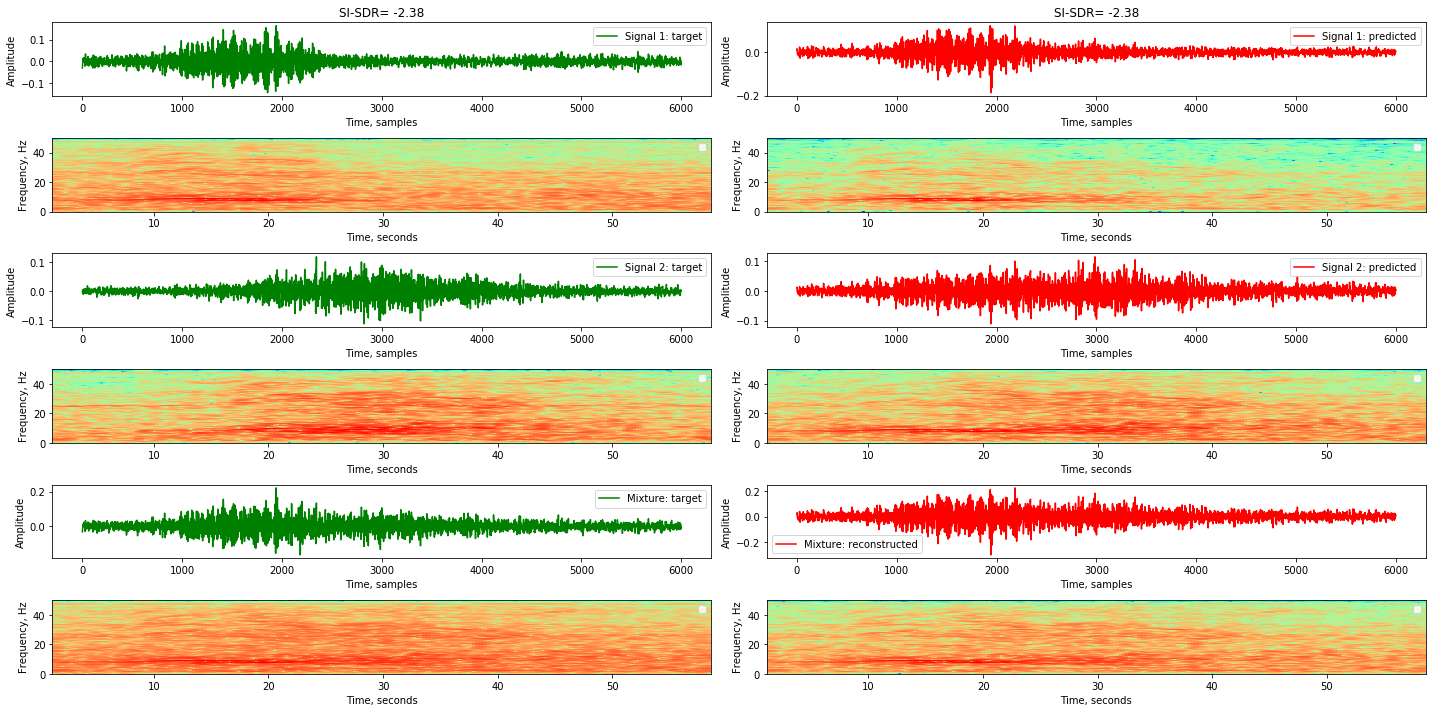

In [ ]:
### MODEL INTERPRETATION
model.eval()
mixture = torch.from_numpy(mix).unsqueeze(0).float().to(device)
est = model(mixture)

nfft = 2**8

signal_1_norm = normalize(signal_1[:,np.newaxis], axis=0).ravel()
signal_2_norm = normalize(signal_2[:,np.newaxis], axis=0).ravel()
signal_norm = torch.from_numpy(np.vstack([signal_1_norm, signal_2_norm])).float().unsqueeze(0)

est_1_norm = normalize(est[0,0,:].detach().cpu()[:,np.newaxis], axis=0).ravel()
est_2_norm = normalize(est[0,1,:].detach().cpu()[:,np.newaxis], axis=0).ravel()
est_norm = torch.from_numpy(np.vstack([est_1_norm, est_2_norm])).float().unsqueeze(0)

loss, reorder_estimate_source = criterion(signal.to(device), est.to(device))
print(loss.item())

fig, ax = plt.subplots(nrows=6, ncols=2, figsize=(20,10), sharex=False, sharey=False)

ax[0,0].plot(signal_1, color='green', label='Signal 1: target')
ax[1,0].specgram(signal_1, NFFT=nfft, Fs=100, noverlap=int(nfft*0.9), cmap='rainbow', label='Signal 1: target');
ax[2,0].plot(signal_2, color='green', label='Signal 2: target')
ax[3,0].specgram(signal_2, NFFT=nfft, Fs=100, noverlap=int(nfft*0.9), cmap='rainbow', label='Signal 2: target');
ax[0,1].plot(reorder_estimate_source[0,0,:].detach().cpu(), color='red', label='Signal 1: predicted')
ax[1,1].specgram(reorder_estimate_source[0,0,:].detach().cpu(), NFFT=nfft, Fs=100, noverlap=int(nfft*0.9), cmap='rainbow', label='Signal 1: predicted');
ax[2,1].plot(reorder_estimate_source[0,1,:].detach().cpu(), color='red', label='Signal 2: predicted')
ax[3,1].specgram(reorder_estimate_source[0,1,:].detach().cpu(), NFFT=nfft, Fs=100, noverlap=int(nfft*0.9), cmap='rainbow', label='Signal 2: predicted');


# loss, reorder_estimate_source = criterion(signal.to(device), est)
# print(loss.item())


# fig, ax = plt.subplots(nrows=3, ncols=2, figsize=(20,10), sharex=True, sharey=True)

# ax[0,0].plot(signal_1, color='green', label='Signal 1: target')
# ax[1,0].plot(signal_2, color='green', label='Signal 2: target')
# ax[0,1].plot(reorder_estimate_source[0,0,:].detach().cpu(), color='red', label='Signal 1: predicted')
# ax[1,1].plot(reorder_estimate_source[0,1,:].detach().cpu(), color='red', label='Signal 2: predicted')

ax[4,0].plot(mix,  color='green', label='Mixture: target')
ax[5,0].specgram(mix, NFFT=nfft, Fs=100, noverlap=int(nfft*0.9), cmap='rainbow', label='Mixture: target');
ax[4,1].plot(torch.sum(reorder_estimate_source, dim=1, keepdim=False).squeeze().detach().cpu(),  
             color='red', label='Mixture: reconstructed')
ax[5,1].specgram(torch.sum(reorder_estimate_source, dim=1, keepdim=False).squeeze().detach().cpu(), NFFT=nfft, Fs=100, noverlap=int(nfft*0.9), cmap='rainbow', label='Mixture: reconstructed');

for a0 in ax:
    for a in a0:
        a.legend()
#     a.set_xlim(2500,3500)

for i in range(2):
    for k in [0,2,4]:
        ax[k,i].set_xlabel('Time, samples')
        ax[k+1,i].set_xlabel('Time, seconds')
        ax[k,i].set_ylabel('Amplitude')
        ax[k+1,i].set_ylabel('Frequency, Hz')
        ax[0,i].set_title('SI-SDR= %.2f' % loss.item())


# ax[0].set_xlim(2500,3000)
plt.tight_layout()
plt.savefig("Sample_4_results.pdf", transparent=True)

In [ ]:
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation
from IPython.display import HTML
import matplotlib.gridspec as gridspec
from scipy.signal import square

with plt.xkcd():
    fig = plt.figure(constrained_layout=True, figsize=(10,5))
    spec = gridspec.GridSpec(ncols=3, nrows=3, figure=fig)
    ax_0 = fig.add_subplot(spec[0, 2])
    ax_1 = fig.add_subplot(spec[2, 2])
    ax_2 = fig.add_subplot(spec[1, 0])
    ax_3 = fig.add_subplot(spec[1, 1])

xdata, ydata_0, ydata_1, ydata_2 = [], [], [], []
ln_0, = ax_0.plot([], [], color='black')
ln_1, = ax_1.plot([], [], color='black')
ln_2, = ax_2.plot([], [], color='red')

def init():
    for ax in [ax_0, ax_1, ax_2]:
        ax.set_xlim(0, 100)
        ax.set_ylim(-2, 2)
    ax_0.set_title('Signal 1')
    ax_1.set_title('Signal 2')
    ax_2.set_title('Mixture')
    ax_3.set_facecolor('black')
    ax_3.set_xticks([])
    ax_3.set_yticks([])
    
    
    ax_3.text(0.5, 0.5, "Machine Learning", size=17, rotation=10.,
         ha="center", va="center",
         bbox=dict(boxstyle="round",
                   ec="#ffbc42",
                   fc='#d81159',
                   )
         )

    return ln_0,ln_1,ln_2

def update(frame):
    xdata.append(frame)
    signal_anim_1 = np.sin(frame/2)
    signal_anim_2 = square(frame/4)
    ydata_2.append(signal_anim_1+signal_anim_2)
    ydata_0.append(signal_anim_1)
    ydata_1.append(signal_anim_2)
    ln_0.set_data(xdata, ydata_0)
    ln_1.set_data(xdata, ydata_1)
    ln_2.set_data(xdata, ydata_2)
    return ln_0,ln_1,ln_2

ani = FuncAnimation(fig, update, frames=np.linspace(0, 100, 100),
                    init_func=init, blit=True, interval=1)
# HTML(ani.to_jshtml())

In [ ]:
ani.save('animation.gif', fps=30)

## MODEL INTERPRETATION

In [ ]:
## TEST ON SYNTH DATA!! VERY INTERESTING!! 

In [ ]:
mixture = torch.from_numpy(mix).unsqueeze(0).float()
encoded = model.encoder(-mixture.to(device))

# attented = model.attn(encoded)
enc_LN = model.enc_LN(encoded)

fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(15,5))

cbar_1 = ax[0].imshow(encoded[0].detach().cpu(), aspect='auto', vmax=0.02, vmin=0)
ax[1].specgram(mixture.detach().squeeze().cpu(), NFFT=64, Fs=100, detrend='linear', noverlap=32);  
ax[0].set_title('Encoder Output')
ax[1].set_title('FFT')
plt.colorbar(cbar_1, ax=ax[0])
# plt.colorbar(cbar_2, ax=ax[1])

plt.tight_layout()
fig.savefig('Encoded.png', dpi=360)

In [ ]:
separator  = model.separator(enc_LN)

fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(20,5))

cbar_1 = ax[0].imshow(separator[0,0,:,:].detach().cpu().T, aspect='auto', cmap='seismic')
cbar_2 = ax[1].imshow(separator[0,1,:,:].detach().cpu().T, aspect='auto', cmap='seismic')

ax[0].set_title('Estimated mask 1')
ax[1].set_title('Estimated mask 2')

plt.colorbar(cbar_1, ax=ax[0])
plt.colorbar(cbar_2, ax=ax[1])
# ax[1,0].specgram(signal_1, NFFT=128, Fs=100, detrend='linear', noverlap=16);  
# ax[1,1].specgram(signal_2, NFFT=128, Fs=100, detrend='linear', noverlap=16);  
# ax[1,0].set_title('FFT signal 1')
# ax[1,1].set_title('FFT signal 2')

plt.tight_layout()
fig.savefig('Separator.png', dpi=360)

In [ ]:
mask_conv1x1 = model.mask_conv1x1(separator.view(1*2, -1, 128).transpose(1, 2).contiguous())

fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(20,5))

cbar_1 = ax[0].imshow(mask_conv1x1[0,:,:].detach().cpu(), aspect='auto', cmap='seismic', vmin=-3)
cbar_2 = ax[1].imshow(mask_conv1x1[1,:,:].detach().cpu(), aspect='auto', cmap='seismic', vmin=-3)

ax[0].set_title('Estimated mask enhanced 1')
ax[1].set_title('Estimated mask enhanced 2')

plt.colorbar(cbar_1, ax=ax[0])
plt.colorbar(cbar_2, ax=ax[1])

# ax[1,0].specgram(signal_2, NFFT=128, Fs=100, detrend='linear', noverlap=16);  
# ax[1,1].specgram(signal_1, NFFT=128, Fs=100, detrend='linear', noverlap=16);  
# ax[1,0].set_title('FFT signal 1')
# ax[1,1].set_title('FFT signal 2')

plt.tight_layout()
fig.savefig('Mask_Estimation.png', dpi=360)

In [ ]:
score = mask_conv1x1.view(1, 2, 128, -1)  # [B*nspk, E, L] -> [B, nspk, E, L]
est_mask = model.gaussian(score)
est_mask = model.upscale(est_mask.permute(0,2,1,3)).permute(0,2,1,3)
est_mask = nn.Softmax(dim=1)(est_mask)

fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(20,5))

cbar_1 = ax[0].imshow(est_mask[0,0,:,:].detach().cpu(), aspect='auto', cmap='seismic')
cbar_2 = ax[1].imshow(est_mask[0,1,:,:].detach().cpu(), aspect='auto', cmap='seismic')
# cbar_3 = ax[1,0].imshow((est_mask[0,0,:,:]+est_mask[0,1,:,:]).detach().cpu(), aspect='auto', cmap='seismic')
# cbar_4 = ax[1,1].imshow(enc_LN[0].detach().cpu(), aspect='auto', cmap='viridis')
# ax[1,0].plot(signal_1, color='black', linewidth=0.25)
# ax[1,1].plot(signal_2, color='black', linewidth=0.25)

ax[0].set_title('Estimated mask 1')
ax[1].set_title('Estimated mask 2')
# ax[1,0].set_title('Sum of masks')
# ax[1,1].set_title('Encoder')

# ax[1,0].set_title('Signal 1')
# ax[1,1].set_title('Signal 2')

plt.colorbar(cbar_1, ax=ax[0])
plt.colorbar(cbar_2, ax=ax[1])
# plt.colorbar(cbar_3, ax=ax[1,0])
# plt.colorbar(cbar_4, ax=ax[1,1])
# ax[1,0].specgram(signal_1, NFFT=128, Fs=100, detrend='linear', noverlap=16);  
# ax[1,1].specgram(signal_2, NFFT=128, Fs=100, detrend='linear', noverlap=16);  
# ax[1,0].set_title('FFT signal 1')
# ax[1,1].set_title('FFT signal 2')

plt.tight_layout()
fig.savefig('Mask_Estimation_Softmax.png', dpi=360)

In [ ]:
# print(est_mask.size())
# # test = torch.stack([torch.ones((1,64,5999)), torch.ones((1,64,5999))], dim=1)
# # test = torch.zeros_like(est_mask)
# # channel = np.random.randint(0,64, (1))
# # test[0,0,channel,:]=1
# # test[0,1,channel,:]=1

# # test = torch.clone(est_mask)
# test = torch.ones_like(est_mask)
# # test[test>0] = 0
# verification = model.decoder(encoded, test)

# plt.plot(verification[0,0,:].detach().cpu(), color='red')
# plt.plot(mix, alpha=0.5, color='green')

# # print(channel)

In [ ]:
decoded = model.decoder(encoded.to(device), est_mask.to(device))
loss, reorded = criterion(torch.stack([torch.from_numpy(signal_1).to(device), torch.from_numpy(signal_2).to(device)]).unsqueeze(0).float(), decoded)

fig, ax = plt.subplots(nrows=2, ncols=2, figsize=(20,7))
ax[0,0].plot(reorded[0,0,:].detach().cpu(), color='red')
ax[0,1].plot(reorded[0,1,:].detach().cpu(), color='red')
ax[1,0].plot(signal_1, color='green', alpha=0.5)
ax[1,1].plot(signal_2, color='green', alpha=0.5)

ax[0,0].set_title('Separated signal 1')
ax[0,1].set_title('Separated signal 2')
ax[1,0].set_title('Original signal 1')
ax[1,1].set_title('Original signal 2')


print(loss.item())

plt.tight_layout()
fig.savefig('Output.png', dpi=360)

In [ ]:
decoded = model.decoder(encoded.to(device), est_mask.to(device))
loss, reorded = criterion(torch.stack([torch.from_numpy(signal_1).to(device), torch.from_numpy(signal_2).to(device)]).unsqueeze(0).float(), decoded)

fig, ax = plt.subplots(nrows=4, ncols=2, figsize=(20,7))
ax[0,0].plot(reorded[0,0,:].detach().cpu(), color='red')
ax[0,1].plot(reorded[0,1,:].detach().cpu(), color='red')
ax[1,0].specgram(reorded[0,0,:].detach().cpu(), NFFT=128, Fs=100, detrend='linear', noverlap=100);
ax[1,1].specgram(reorded[0,1,:].detach().cpu(), NFFT=128, Fs=100, detrend='linear', noverlap=100);

ax[2,0].plot(signal_1, color='green', alpha=0.5)
ax[2,1].plot(signal_2, color='green', alpha=0.5)
ax[3,0].specgram(signal_1, NFFT=128, Fs=100, detrend='linear', noverlap=100);
ax[3,1].specgram(signal_2, NFFT=128, Fs=100, detrend='linear', noverlap=100);

ax[0,0].set_title('Separated signal 1')
ax[0,1].set_title('Separated signal 2')
ax[1,0].set_title('Separated signal 1 STFT')
ax[1,1].set_title('Separated signal 2 STFT')
ax[2,0].set_title('Original signal 1')
ax[2,1].set_title('Original signal 2')
ax[3,0].set_title('Original signal 1 STFT')
ax[3,1].set_title('Original signal 2 STFT')

# print(loss.item())

plt.tight_layout()
fig.savefig('Output_STFT.png', dpi=360)

In [ ]:
fig, ax = plt.subplots(nrows=2, ncols=1, figsize=(20,7))
ax[0].plot(mix, color='#FA7921')
# ax[0,1].plot(reorded[0,1,:].detach().cpu(), color='red')
ax[1].specgram(mix, NFFT=128, Fs=100, detrend='linear', noverlap=100);
# ax[1,1].specgram(reorded[0,1,:].detach().cpu(), NFFT=128, Fs=100, detrend='linear', noverlap=100);
ax[0].set_title('Input mixture')
ax[1].set_title('Input mixture STFT')

plt.tight_layout()
fig.savefig('Mixture_STFT.png', dpi=360)

In [ ]:
### TESTING§

In [ ]:
import optuna
import time

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu') 

DIR = os.getcwd()
EPOCHS = 1
LOG_INTERVAL = 10
BATCHSIZE        = 32
N_TRAIN_EXAMPLES = 10000
N_VAL_EXAMPLES   = 1000


def get_data(dataset_train, dataset_test):
    train_loader = DataLoader(
    torch.utils.data.Subset(dataset_train, list(range(N_TRAIN_EXAMPLES))),
    batch_size=BATCHSIZE,
    num_workers=os.cpu_count(), 
    pin_memory=True,
    shuffle = False,
    worker_init_fn=worker_init_fn
    )

    test_loader = DataLoader(
    torch.utils.data.Subset(dataset_test, list(range(N_VAL_EXAMPLES))),
    batch_size=BATCHSIZE,
    num_workers=os.cpu_count(), 
    pin_memory=True,
    shuffle = False,
    worker_init_fn=worker_init_fn
    )

    return train_loader, test_loader


def objective(trial):
    lr   = 1e-3
    clip = 7.5
    
    enc_dim     = trial.suggest_int('enc_dim_scale', 0, 8, 1)
    feature_dim = trial.suggest_int('feature_dim_scale', 0, 8, 1)
    hidden_dim  = trial.suggest_int('hidden_dim_scale', 0, 8, 1)
    segment_size= trial.suggest_int('segment', 10, 5000, 200)
    
    model = FaSNet_base(enc_dim=2**enc_dim, feature_dim=2**feature_dim, hidden_dim=2**hidden_dim, layer=1, 
                    segment_size=400, nspk=2, win_len=2).to(device)
    
    criterion = SI_SDR_Loss()
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)

    # Get the dataset.
    train_loader, val_loader = get_data(dataset_train, dataset_test)

    # Training of the model.
    for epoch in range(EPOCHS):
        train_loss = 0
        model.train()
        for batch_idx, signal in enumerate(train_loader):
                signal, n_sources = signal
                signal  = signal.to(device)
                mix     = torch.sum(signal, dim=1, keepdim=False)
                estimates = model(mix)
                
                optimizer.zero_grad()
                loss, reorder_estimate_source = criterion(signal, estimates)
                train_loss += loss
                loss.backward()
                torch.nn.utils.clip_grad_norm_(model.parameters(), clip)
                optimizer.step()
                if( batch_idx % 10) == 0:
                    print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.3e}'.format(
                    epoch, batch_idx * len(signal), len(train_loader.dataset),
                    100. * batch_idx / len(train_loader),
                    loss.item())) 
    
    
#     return test_loss/len(test_loader.dataset) 
    return train_loss/len(train_loader.dataset) 


if __name__ == "__main__":
    study = optuna.create_study(direction='minimize', study_name='HP_search_1', storage='sqlite:///example.db', load_if_exists=True)
    study.optimize(objective, n_trials=100)

    print("Number of finished trials: ", len(study.trials))

In [ ]:
import optuna
study = optuna.create_study(direction='minimize', study_name='HP_search_1', 
                            storage='sqlite:///example.db', load_if_exists=True)
optuna.visualization.plot_contour(study, params=['enc_dim_scale', 'feature_dim_scale', 'hidden_dim_scale'])

In [ ]:
optuna.visualization.plot_optimization_history(study)

In [ ]:
optuna.visualization.plot_parallel_coordinate(study)#, params=['enc_dim', 'fea'])

In [ ]:
optuna.visualization.plot_slice(study)

In [ ]:
study.best_params

In [ ]:
# cuda setup
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu') 

model = FaSNet_base(enc_dim=128, feature_dim=128, hidden_dim=64, layer=1, #3
                    segment_size=400, nspk=2, win_len=2).to(device)



In [ ]:
criterion = SI_SDR_Loss()
bests = []
for i in range(90,200):
    model.load_state_dict(torch.load('attention/trained_%i.pt' % i, map_location=torch.device(device)))

    model.eval()
    test_loss = 0

    with torch.no_grad():
        for batch_idx, signal in enumerate(valid_loader):

            signal  = signal[0].to(device)
            mix     = torch.sum(signal, dim=1, keepdim=False)

            estimates = model(mix)

            loss, reorder_estimate_source = criterion(signal, estimates)
            test_loss += loss.detach().cpu().numpy()

    bests.append({i : test_loss/len(valid_loader)})
    print(i, test_loss/len(valid_loader))

In [ ]:
epochs = []
values = []
for d in bests:
    epochs.append([key for key in d.keys()][0])
    values.append([value for value in d.values()][0])

In [ ]:
epochs[np.argmin(values)]

In [ ]:
# test_japan = np.load('/content/drive/My Drive/TraML/Japan_full.npy')
# test_filt = np.load('/content/drive/My Drive/TraML/Japan_filt.npy')

merged = np.load('/content/drive/My Drive/TraML/Trains.npy')
u4 = np.load('/content/drive/My Drive/TraML/U4.npy')
u6 = np.load('/content/drive/My Drive/TraML/U6.npy')

In [ ]:
signal = normalize(u6[:,np.newaxis], axis=0).ravel()
signal = torch.from_numpy(signal).float()
mix  = signal.unsqueeze(1).T.to(device) #estimates[0][0].unsqueeze(1).T
# mix     = torch.sum(signal, dim=1, keepdim=False)
model.eval()
with torch.no_grad():  
    estimates = model(mix)     
# loss, reorder_estimate_source = criterion(signal, estimates)


In [ ]:
fig, ax = plt.subplots(nrows=3, ncols=1, figsize=(20,9))
idx = 0
separate_1 = normalize(estimates[idx][0].detach().cpu()[:,np.newaxis], axis=0).ravel()
separate_2 = normalize(estimates[idx][1].detach().cpu()[:,np.newaxis], axis=0).ravel()
u4 = normalize(u4[:,np.newaxis], axis=0).ravel()
u6 = normalize(u6[:,np.newaxis], axis=0).ravel()

ax[0].plot(signal.detach().cpu(), color='red', label='Input signal')
ax[1].plot(separate_1, label='Predicted', color='blue')
# ax[1].plot(u4, label='Original', color='green', alpha=0.5)
ax[1].set_title('Correlation = %.2f' % np.corrcoef(separate_1, u4)[1,0])

ax[2].plot(separate_2, label='Predicted', color='purple')
# ax[2].plot(u6, label='Original', color='green', alpha=0.5)
ax[2].set_title('Correlation = %.2f' % np.corrcoef(separate_2, u6)[1,0])

# ax[0,1].plot(test_filt, color='green', label='Lowpass: 0.6 Hz Input Signal')
# ax[1,1].plot(lowpass_biquad(torch.from_numpy(separate_1), 100, 0.6), color='blue', label='Lowpass: 0.6 Hz Source 1')
# ax[2,1].plot(lowpass_biquad(torch.from_numpy(separate_2), 100, 0.6), color='purple', label='Lowpass: 0.6 Hz Source 2')


for a in ax:
    a.legend()

In [ ]:
from scipy.signal import correlate
np.corrcoef(separate_1, noise_1)
# plt.plot(correlate(noise_1, ))

In [ ]:
fig, ax = plt.subplots(3, figsize=(20,9))
ax[0].plot(lowpass_biquad(torch.from_numpy(separate_2), 100, 0.6))
ax[1].plot(test_filt, color='red')
ax[2].plot(test_japan, color='green')

In [ ]:
data_win.shape

In [ ]:
from sklearn.preprocessing import normalize
import matplotlib.gridspec as gridspec
from scipy.signal import correlate
# plt.plot(correlate(signal_norm_1, estimates_norm_1, mode='same', method='auto'))

fig = plt.figure(constrained_layout=True, figsize=(20,9))
spec = gridspec.GridSpec(ncols=2, nrows=3, figure=fig)

ax0 = fig.add_subplot(spec[0, :])

ax1 = fig.add_subplot(spec[1, 0])
ax2 = fig.add_subplot(spec[1, 1])

# ax3 = fig.add_subplot(spec[2, 0])
# ax4 = fig.add_subplot(spec[2, 1])

ax5 = fig.add_subplot(spec[2, 0])
ax6 = fig.add_subplot(spec[2, 1])

# fig, ax = plt.subplots(nrows=3, ncols=2, sharex=False, sharey=False, figsize=(20,5))

idx = 1
zoom_1 = 1250
zoom_2 = 1750

# signal_norm_1 = normalize(signal[idx,0,:].detach().cpu()[:,np.newaxis], 'l1', axis=0).ravel()
# estimates_norm_1 = normalize(reorder_estimate_source[idx,0,:].detach().cpu()[:,np.newaxis], 'l1', axis=0).ravel()
signal_norm_1 = 
residual_1 = signal_norm_1-estimates_norm_1
residual_1 = normalize(residual_1[:,np.newaxis], axis=0).ravel()
corr_1 = np.corrcoef(signal_norm_1, estimates_norm_1)[0,1]

signal_norm_2 = normalize(signal[idx,1,:].detach().cpu()[:,np.newaxis], 'l1', axis=0).ravel()
estimates_norm_2 = normalize(reorder_estimate_source[idx,1,:].detach().cpu()[:,np.newaxis], 'l1', axis=0).ravel()
residual_2 = signal_norm_2-estimates_norm_2
residual_2 = normalize(residual_2[:,np.newaxis], axis=0).ravel()
corr_2 = np.corrcoef(signal_norm_2, estimates_norm_2)[0,1]

ax0.plot(signal[idx,0,:].detach().cpu()+signal[idx,1,:].detach().cpu(), label='Mixture', color='#e55934')
ax0.set_title('Input mixture')
ax0.set_ylabel('Amplitude')
ax0.set_xlabel('Time, samples')

ax1.plot(estimates_norm_1, color='purple', linewidth=1, label='Predicted')
ax1.plot(signal_norm_1, color='#1fd224', alpha=0.5, linewidth=1, label='Original')
# ax3.plot(residual_1, color='black', linewidth=0.5, label='RMS error')
ax1.set_title('Denoised signal (L1 normalized). Correlation=%.2f' % (corr_1))
ax1.set_ylabel('Amplitude')
ax1.set_xlabel('Time, samples')

ax1.axvline(zoom_1, color='red')
ax1.axvline(zoom_2, color='red')

ax2.plot(estimates_norm_2, color='purple', linewidth=1, label='Predicted')
ax2.plot(signal_norm_2, color='#1fd224', alpha=0.5, linewidth=1, label='Original')
# ax4.plot(residual_2, color='black', linewidth=0.5, label='RMS error')
ax2.set_title('Added noise (L1 normalized). Correlation=%.2f' % (corr_2))
ax2.set_ylabel('Amplitude')
ax2.set_xlabel('Time, samples')

ax2.axvline(zoom_1, color='red')
ax2.axvline(zoom_2, color='red')

# ax5.plot(signal_norm_1+signal_norm_2, color='#e55934', alpha=0.5, linewidth=1, label='Mixture')
ax5.plot(estimates_norm_1, color='purple', alpha=0.5, linewidth=2, label='Predicted')
ax5.plot(signal_norm_1, color='#1fd224', alpha=0.5, linewidth=2, label='Original')
ax5.set_title('Zoom')
ax5.set_ylabel('Amplitude')
ax5.set_xlabel('Time, samples')

# ax6.plot(signal_norm_1+signal_norm_2, color='#e55934', alpha=0.5, linewidth=1, label='Mixture')
ax6.plot(estimates_norm_2, color='purple', alpha=0.5, linewidth=2, label='Predicted')
ax6.plot(signal_norm_2, color='#1fd224', alpha=0.5, linewidth=2, label='Original')
ax6.set_title('Zoom')
ax6.set_ylabel('Amplitude')
ax6.set_xlabel('Time, samples')

ax5.set_xlim(zoom_1, zoom_2)
ax6.set_xlim(zoom_1, zoom_2)

ax0.legend()
ax1.legend()
ax2.legend()
ax5.legend()
ax6.legend()

In [ ]:
sum(p.numel() for p in model.parameters())

In [ ]:
if  state == 1:
                
            if state == -1:
                signal = highpass_biquad(signal, 100, np.random.randint(1, 49))
            if state == 0:
                signal = signal

In [ ]:
signal_1 = signal[0,0,:].detach().cpu()[100:200]
signal_2 = signal[0,1,:].detach().cpu()[100:200]

with plt.xkcd():
    fig, ax = plt.subplots(nrows=1, figsize=(10,3), sharex=True, sharey=True)
    signal_new = signal_2
    # signal_new = signal_new.roll(np.random.randint(-len(signal_new)+1, len(signal_new)-1))
    signal_new = highpass_biquad(signal_new, 100, 40)
    ax.plot(signal_new, color='#00a5cf')
    # ax[1].plot(signal_1, color='#00a5cf')
    # ax[2].plot(signal_1+signal_2, color='#e55934')

    # ax[0].set_title('Source 1')
    # ax[1].set_title('Source 2')
    # ax[2].set_title('Resulting mixture')

    # for a in ax:
        # a.set_ylabel('Amplitude')
        # a.set_xlabel('Time, samples')
    ax.set_xticks([])
    ax.set_yticks([])